<a href="https://colab.research.google.com/github/SOL1archive/KoGrammar/blob/main/distil_train_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
  import google.colab
  IN_COLAB = True
  
except:
  IN_COLAB = False

IN_COLAB

True

In [ ]:
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install rouge_score
!pip install torchmetrics
!pip install --upgrade accelerate
!pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import datetime
import os
import gc
from collections import namedtuple
from pprint import pprint
from tqdm import tqdm

import numpy as np
import pandas as pd

import tensorboard
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
import torchmetrics

from datasets import load_dataset, load_from_disk, concatenate_datasets, DatasetDict, Dataset
from transformers import DataCollatorForSeq2Seq
from transformers import BartConfig, T5Config
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
import evaluate
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

## Settings

In [ ]:
MANUAL_TRAINING = True
MANUAL_VALIDATION = True
NUM_EPOCHS = 1
MID_CHECKPOINT_NUM = 1  # 중간 저장 횟수
MID_PROCESS_PRINT_NUM = 50  # 중간 진행 상황 출력 횟수
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Loading Tokenizer & Model Checkpoint

In [ ]:
config = BartConfig.from_json_file('./drive/MyDrive/text_processing/config.json')
tokenizer = AutoTokenizer.from_pretrained("./drive/MyDrive/text_processing/")
checkpoint = torch.load('./drive/MyDrive/text_processing/pytorch_model.bin')
model = AutoModelForSeq2SeqLM.from_config(config)
model_distil = AutoModelForSeq2SeqLM.from_config(config)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


In [ ]:
model.load_state_dict(checkpoint)
model_distil.load_state_dict(checkpoint)

<All keys matched successfully>

In [ ]:
model_distil.model.decoder.layers = nn.Sequential(model.model.decoder.layers[0], 
                                           model.model.decoder.layers[2],
                                           model.model.decoder.layers[5],)

## Loading Datasets

In [ ]:
tokenized_dataset_path = './drive/MyDrive/text_processing/dataset'

In [ ]:
tokenized_dataset = load_from_disk(tokenized_dataset_path)

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1016426
    })
    train_baseline: Dataset({
        features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 508213
    })
    train_distil: Dataset({
        features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 508212
    })
    valid: Dataset({
        features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 56468
    })
    test: Dataset({
        features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 56469
    })
})

## Training

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    report_to="tensorboard",
    push_to_hub=False,
)

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_distil, return_tensors='pt')

In [ ]:
trainer = Seq2SeqTrainer(
    model=model_distil,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['valid'],
    data_collator=data_collator,
)

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:

total_loss_lt = []
batch_loss_lt = []

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
optimizer = AdamW(model_distil.parameters(), lr=2e-5)
trainset = tokenized_dataset['train_distil'].with_format("torch", device=device)
dataloader = DataLoader(trainset, 
                        batch_size=35, 
                        shuffle=True, 
                        #collate_fn=lambda lt: pad_sequence(lt, 
                        #                                   batch_first=True, 
                        #                                   padding_value=tokenizer.pad_token_id
                        #                                   )
                        )
if not next(model_distil.parameters()).is_cuda and device == torch.device('cuda'):
    model_distil.to(device)

model_distil.train()
for epoch in range(NUM_EPOCHS):
    total_steps = len(dataloader)
    save_divisor = total_steps // MID_CHECKPOINT_NUM
    print_divisor = total_steps // MID_PROCESS_PRINT_NUM
    
    for i, batch in enumerate(tqdm(dataloader)):
        X = {
                'input_ids': batch['input_ids'],
                'attention_mask': batch['attention_mask'],
            }
        y = batch['labels']
        
        outputs = model_distil(**X, labels=y)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        batch_loss_lt.append(loss.item())

        # if i % print_divisor == print_divisor - 1:
        #     total_loss_lt += batch_loss_lt
        #     batch_loss_series = pd.Series(batch_loss_lt)
        #     print(f'\tbatch {i}\tloss: {loss.item()}\tmean: {batch_loss_series.mean()}')
        #     batch_loss_lt = []
        
        # if i % save_divisor == save_divisor - 1:
        #     SAVE_STR = datetime.datetime.now().strftime('%y%m%d-%H:%M') + f'-batch{i}'
        #     trainer.create_model_card(
        #         language='Korean',
        #         tags='Grammar',
        #         finetuned_from=checkpoint
        #     )
        #     trainer.save_model(f"drive/MyDrive/projects/KoGrammar/models/{SAVE_STR}")

    total_loss_lt += batch_loss_lt
    batch_loss_series = pd.Series(batch_loss_lt)
    print(f'epoch {epoch + 1} loss: {loss.item()} mean: {batch_loss_series.mean()}')


100%|██████████| 14521/14521 [3:14:35<00:00,  1.24it/s]

epoch 1 loss: 0.0018746176501736045 mean: 0.006414726848103348


<Axes: >

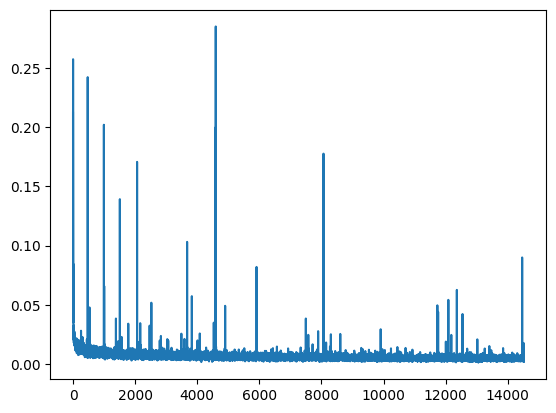

In [ ]:
total_loss_series = pd.Series(total_loss_lt)
total_loss_series.plot.line()

## Validation

In [ ]:
def generate_seq(model, tokenizer, input):
    generated_ids = model.generate(**input)
    generated_text = tokenizer.decode(generated_ids.squeeze(0), skip_special_tokens=True)
    
    return generated_text

def generate_input_target(model, tokenizer, input, label):
    input_text = tokenizer.decode(input['input_ids'].squeeze(0), skip_special_tokens=True)
    generated_text = generate_seq(model, tokenizer, input)
    target_text = tokenizer.decode(label.squeeze(0), skip_special_tokens=True)
    
    return {
        'input_text': input_text,
        'generated_text': generated_text, 
        'target_text': target_text
    }

def generate_from_data(model, tokenizer, data):
    label = data['labels']
    input_data = dict()
    input_data['input_ids'] = data['input_ids']
    input_data['attention_mask'] = data['attention_mask']

    return generate_input_target(model, tokenizer, input_data, label)

def eval(model, tokenizer, input_seq, label, metric, options = dict()):
    generated_input_target = generate_input_target(model, tokenizer, input_seq, label)
    score = metric.compute(
        generated_input_target['generated_text'], 
        generated_input_target['target_text'],
        **options
    )

    return score

In [ ]:
model.eval()
model_distil.eval()
model.to(device)
model_distil.to(device)
validset = tokenized_dataset['valid'].with_format("torch", device=device)
index_select = 100
test_sample = validset.select(range(index_select,index_select+1))
test_sample_gt = test_sample['labels']
test_sample = test_sample.remove_columns('labels')[0]
test_sample_input = dict()
test_sample_input['input_ids'] = test_sample['input_ids'].unsqueeze(0)
test_sample_input['attention_mask'] = test_sample['attention_mask'].unsqueeze(0)
output = model.generate(**test_sample_input)
output_distil = model_distil.generate(**test_sample_input)
input_text = tokenizer.decode(test_sample_input['input_ids'].squeeze(0), skip_special_tokens=True)
output_text = tokenizer.decode(output.squeeze(0), skip_special_tokens=True)
output_distil_text = tokenizer.decode(output_distil.squeeze(0), skip_special_tokens=True)
gt_text = tokenizer.decode(test_sample_gt.squeeze(0), skip_special_tokens=True)

print(input_text)
print(output_text)
print(output_distil_text)
print(gt_text)

나두안봤어
나도 안 봤어.
나도 안 봤어.
나도 안 봤어.


In [ ]:
accuracy_lt = []
bleu_score_lt = []
rouge_score_lt = []
accuracy = evaluate.load('accuracy')
bleu = evaluate.load('google_bleu')
rouge = Rouge()

for example in tqdm(validset.shuffle().select(range(2000))):
    data = dict()
    for key in example:
        data[key] = example[key].unsqueeze(0)
    output = generate_from_data(model_distil, tokenizer, data)
    generated_text = output['generated_text']
    target_text = output['target_text']

    try:
        bleu_score = sentence_bleu([target_text], generated_text, smoothing_function=SmoothingFunction().method1)
        rouge_score = rouge.get_scores(generated_text, target_text)[0]['rouge-2']['f']
    except ValueError:
        continue

    bleu_score_lt.append(bleu_score)
    rouge_score_lt.append(rouge_score)

bleu_score_series = pd.Series(bleu_score_lt)
rouge_score_series = pd.Series(rouge_score_lt)
print(bleu_score_series.mean(), rouge_score_series.mean(), sep='\t')
result_df = pd.concat([bleu_score_series, rouge_score_series], axis=1)

100%|██████████| 2000/2000 [03:07<00:00, 10.68it/s]

0.8515582402762971	0.6488850507188535


In [ ]:
NOW_STR = datetime.datetime.now().strftime('%y%m%d-%H:%M')
result_df.columns = ['BLEU-2', 'ROUGE-2 F1']
result_df.to_csv(f'./drive/MyDrive/text_processing/result-data/{NOW_STR}-distil-valid_result.csv')
result_df.describe()

,BLEU-2,ROUGE-2 F1
count,1969.000000,1969.000000
mean,0.851558,0.648885
std,0.230393,0.427583
min,0.000000,0.000000
25%,0.782200,0.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


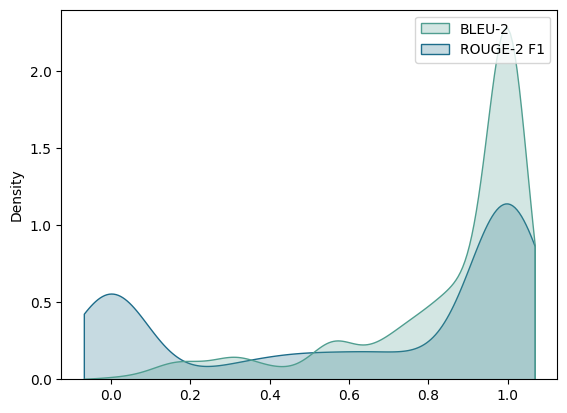

In [ ]:
ax = sns.kdeplot(data=result_df, fill=True, palette="crest", common_grid=True, cut=1)

## Saving

In [ ]:
NOW_STR = datetime.datetime.now().strftime('%y%m%d-%H:%M')
trainer.create_model_card(
    language='Korean',
    tags='Grammar',
    #model='KoGrammar',
    finetuned_from=checkpoint
)
trainer.save_model(f"drive/MyDrive/text_processing/saved_model/{NOW_STR}")